In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, util, transform
from skimage.transform import AffineTransform
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

In [2]:
%matplotlib inline

In [3]:
mask = data.binary_blobs(length=512, blob_size_fraction=0.07, volume_fraction=.25, seed=1)
image = np.random.normal(loc = .7, scale=.3, size=mask.shape)
image[np.invert(mask)] = .3

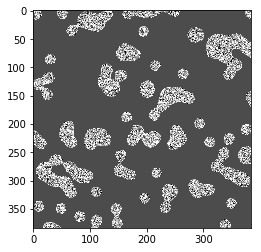

In [13]:
fig, ax = plt.subplots()
edge = 64
crop = np.s_[edge:(image.shape[0]-edge),edge:(image.shape[1]-edge)]
im = ax.imshow(image[crop], cmap='gray', vmin=0, vmax=1.0, animated=True)

walk = np.random.choice(np.arange(-3,3,.1), size=(100,2))
walk = np.cumsum(walk, axis=0)

def animate(i):
    global image
    global walk
    xform = AffineTransform(translation=walk[i])
    capture = transform.warp(image, xform)
    noise = util.random_noise(capture, var=.1)
    im.set_data(noise[crop])
    return im,

In [14]:
anim = animation.FuncAnimation(fig, animate, frames=walk.shape[0], interval=50, blit=True)
rc('animation', html='html5')
anim

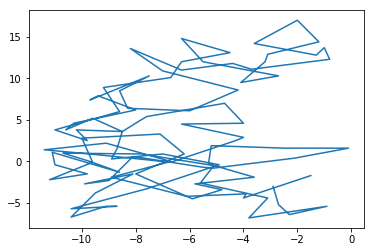

In [15]:
fig2, ax2 = plt.subplots()
ax2.plot(walk[:,0], walk[:,1])
ax2.autoscale()